In [50]:
# auto load all the functions
%load_ext autoreload
%autoreload 2
import pandas as pd


from pca_split import pca_split_and_save, calculate_descriptors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calculate molecular descriptors for PCA

In [13]:
file = '../C18RT.csv'
df = pd.read_csv(file)
df = df[['C18RT','CanonicalSMILES']]

features = calculate_descriptors(df)

/Users/shunyang.wang/miniconda3/envs/autogluon/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
[00:14:11] SMILES Parse Error: syntax error while parsing: CC(=C)[C@H]1CCC(=CC1)CO,
[00:14:11] SMILES Parse Error: Failed parsing SMILES 'CC(=C)[C@H]1CCC(=CC1)CO,' for input: 'CC(=C)[C@H]1CCC(=CC1)CO,'
[00:27:36] SMILES Parse Error: syntax error while parsing: C[C@@H]([C@@H](C1=CC=CC=C1)O)NC,
[00:27:36] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]([C@@H](C1=CC=CC=C1)O)NC,' for input: 'C[C@@H]([C@@H](C1=CC=CC=C1)O)NC,'
[00:28:02] SMILES Parse Error: syntax error while parsing: C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2OC(=O)CCC(=O)O)OC(=O)CCC(=O)O)CCC4=C3C=CC(=C4)O,
[00:28:02] SMILES Parse Error: Failed parsing SMILES 'C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2OC(=O)CCC(=O)O)OC(=O)CCC(=O)O)CCC4=C3C=CC(=C4)O,' for input: 'C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2OC(=O)CCC(=

In [26]:
# clean the data
# convert to float,  strings
tmp_features = features.iloc[:,2:].apply(pd.to_numeric, errors='coerce')
# replace NaN with 0
tmp_features.fillna(0, inplace=True)

## Train test split, PCA visulization 

In [51]:
train, test  = pca_split_and_save(tmp_features)

Splitting the dataset using stratified method...
saving the dataframes as csv files


/Users/shunyang.wang/miniconda3/envs/autogluon/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Baseline model

In [74]:
# get baseline regression model using XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

y_train = df.iloc[train.index]['C18RT']
y_test = df.iloc[test.index]['C18RT']
X_train, X_test = train, test
# Train Baseline Model
baseline_model = XGBRegressor(random_state=999)# reproducibility
baseline_model.fit(X_train, y_train)

# Predictions
train_pred = baseline_model.predict(X_train)
test_pred = baseline_model.predict(X_test)

# Evaluate Model
r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, test_pred)

mae = mean_absolute_error(y_test, test_pred)


print(f"Train R2: {r2_train:.4f}")
print(f"Test R2: {r2_test:.4f}")
print(f"MAE: {mae:.4f}")


Train R2: 0.9976
Test R2: 0.8336
MAE: 0.4604


In [75]:
# Feature Importances
feature_importances = baseline_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print top 10 features
print("Top 10 important features:")
print(feature_importance_df.head(10))

# Select top 100 most important features
top_200_features = feature_importance_df.head(100)['Feature']
X_train_selected = X_train[top_200_features]
X_test_selected = X_test[top_200_features]

# Print the shape of the new dataset
print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_selected.shape[1]}")



Top 10 important features:
             Feature  Importance
1553           SLogP    0.163085
1275            BIC0    0.097576
440          AATSC0i    0.054507
1333      SlogP_VSA5    0.029593
1257             IC0    0.023526
3              nBase    0.021050
1214       AETA_beta    0.019901
296          ATSC0se    0.016422
1156          MINaaN    0.015074
1247  ETA_dEpsilon_D    0.013121
Original number of features: 1613
Reduced number of features: 100


In [76]:
# Train a new model on selected features (for demonstration)
next_model = XGBRegressor(random_state=999)
next_model.fit(X_train_selected, y_train)

# Evaluate the new model
train_pred_selected = next_model.predict(X_train_selected)
test_pred_selected = next_model.predict(X_test_selected)

r2_train_selected = r2_score(y_train, train_pred_selected)
r2_test_selected = r2_score(y_test, test_pred_selected)
mae_selected = mean_absolute_error(y_test, test_pred_selected)

print(f"New Model Train R2: {r2_train_selected:.4f}")
print(f"New Model Test R2: {r2_test_selected:.4f}")
print(f"New Model MAE: {mae_selected:.4f}")

New Model Train R2: 0.9967
New Model Test R2: 0.8397
New Model MAE: 0.4474


## Baseline model with regularizations

In [78]:
# Define target and features
y_train = df.loc[train.index, 'C18RT']
y_test = df.loc[test.index, 'C18RT']
X_train, X_test = train[top_200_features], test[top_200_features]  # Use reduced features

# Train Model with L1 and L2 Regularization
regularized_model = XGBRegressor(
    random_state=999,   # Reproducibility
    reg_alpha=10.0,      # L1 regularization strength
    reg_lambda=10.0,     # L2 regularization strength
    n_estimators=100,   # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6         # Maximum depth of trees
)
regularized_model.fit(X_train, y_train)

# Predictions
train_pred = regularized_model.predict(X_train)
test_pred = regularized_model.predict(X_test)

# Evaluate Model
r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)

# Print Evaluation Results
print(f"Train R2: {r2_train:.4f}")
print(f"Test R2: {r2_test:.4f}")
print(f"MAE: {mae:.4f}")

# Feature Importances
feature_importances = regularized_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': top_200_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print Top 10 Features
print("Top 10 important features after regularization:")
print(feature_importance_df.head(10))

Train R2: 0.9458
Test R2: 0.8493
MAE: 0.4435
Top 10 important features after regularization:
             Feature  Importance
1553           SLogP    0.276282
1275            BIC0    0.099264
3              nBase    0.073552
1333      SlogP_VSA5    0.049612
225           AATS1i    0.038628
1269            SIC0    0.033695
1312       PEOE_VSA6    0.028626
1247  ETA_dEpsilon_D    0.025908
1385          AMID_N    0.024682
440          AATSC0i    0.022091


## Cross-validation

In [84]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import pandas as pd

# Define target and features
y = df['C18RT']
X = tmp_features[top_200_features]  # Use reduced features

# Initialize the model with regularization
model = XGBRegressor(
    random_state=999,
    reg_alpha=10.0,  # L1 regularization
    reg_lambda=10.0,  # L2 regularization
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=999)

# Lists to store metrics for each fold
train_r2_scores = []
test_r2_scores = []
mae_scores = []

# Perform cross-validation
print("Starting cross-validation...\n")
for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    # Split data into train and test for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate metrics
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    mae = mean_absolute_error(y_test, test_pred)

    # Store metrics
    train_r2_scores.append(r2_train)
    test_r2_scores.append(r2_test)
    mae_scores.append(mae)

    # Print metrics for this fold
    print(f"Fold {fold}:")
    print(f"  Train R2: {r2_train:.4f}")
    print(f"  Test R2: {r2_test:.4f}")
    print(f"  MAE: {mae:.4f}\n")

# Print average metrics across all folds
print("Cross-validation results:")
print(f"  Average Train R2: {sum(train_r2_scores) / len(train_r2_scores):.4f}")
print(f"  Average Test R2: {sum(test_r2_scores) / len(test_r2_scores):.4f}")
print(f"  Average MAE: {sum(mae_scores) / len(mae_scores):.4f}")


Starting cross-validation...

Fold 1:
  Train R2: 0.9466
  Test R2: 0.8440
  MAE: 0.4419

Fold 2:
  Train R2: 0.9433
  Test R2: 0.8785
  MAE: 0.4182

Fold 3:
  Train R2: 0.9456
  Test R2: 0.8698
  MAE: 0.4222

Fold 4:
  Train R2: 0.9439
  Test R2: 0.8540
  MAE: 0.4456

Fold 5:
  Train R2: 0.9478
  Test R2: 0.8332
  MAE: 0.4496

Cross-validation results:
  Average Train R2: 0.9454
  Average Test R2: 0.8559
  Average MAE: 0.4355


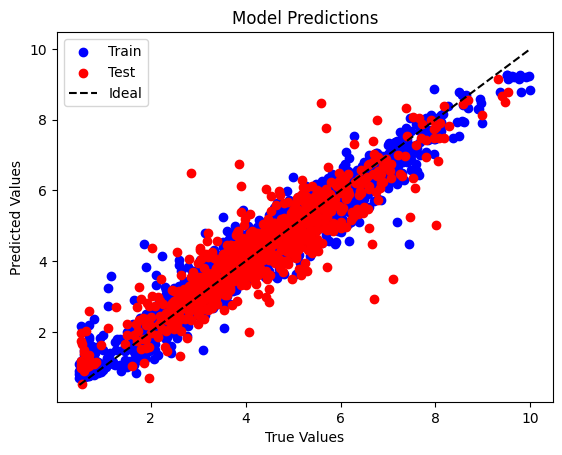

In [85]:
import matplotlib.pyplot as plt

# Scatter plot for training predictions
plt.scatter(y_train, train_pred, color='blue', label='Train')
# Scatter plot for test predictions
plt.scatter(y_test, test_pred, color='red', label='Test')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='black', linestyle='--', label='Ideal')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("Model Predictions")
plt.show()
